In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

In [2]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')

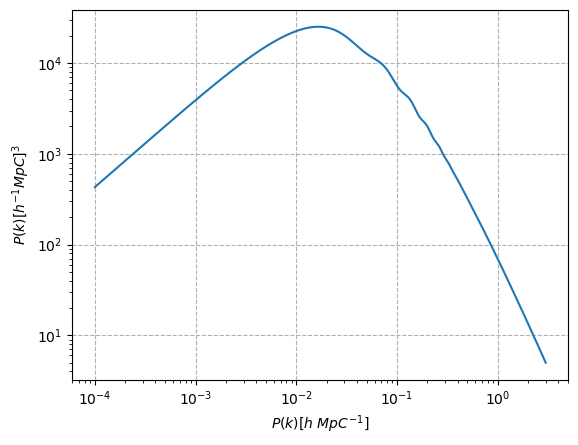

In [21]:
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$P(k) [h~MpC^{-1}]$')
plt.yscale('log')
plt.xscale('log')

In [208]:
L=10
test = np.arange(int(L/2)+1)
ph = np.random.uniform(-10,10,size = int(L/2))
testing = np.zeros((L),dtype=complex)  
for i in range(1,int(L/2)):
    testing[i]=test[i]+ph[i-1]*1j
    testing[10-i]=test[i]-ph[i-1]*1j
testing[int(L/2)]=test[int(L/2)]+ph[int(L/2)-1]*1j
testing[0]=sum(testing.real)
testing[int(L/2)]=testing[int(L/2)].real

In [209]:
testing #k space  (WORKS!)

array([25.+0.j        ,  1.+7.05983271j,  2.+8.68386455j,  3.+9.41816634j,
        4.-4.02702187j,  5.+0.j        ,  4.+4.02702187j,  3.-9.41816634j,
        2.-8.68386455j,  1.-7.05983271j])

In [210]:
np.fft.ifft(testing,norm="backward")

array([ 5.        +0.j, -2.34695278+0.j,  0.47747729+0.j,  3.89836005+0.j,
        1.05698958+0.j,  2.4       +0.j,  3.94301042+0.j,  0.79606714+0.j,
        4.52252271+0.j,  5.25252559+0.j])

In [214]:
test2d = np.arange(16).reshape(4,4)

In [215]:
np.fft.fft2(test2d,norm="forward")

array([[ 7.5+0.j , -0.5+0.5j, -0.5+0.j , -0.5-0.5j],
       [-2. +2.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ],
       [-2. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ],
       [-2. -2.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ]])

In [203]:
import numpy as np

# Create a Hermitian matrix
hermitian_matrix = np.array([[1+0j, 2-3j, 4+1j],
                             [2+3j, 5+0j, 6+2j],
                             [4-1j, 6-2j, 7+0j]])

# # Check if the matrix is Hermitian
# is_hermitian = np.allclose(hermitian_matrix, hermitian_matrix.conj().T)

# print("Is the matrix Hermitian?", is_hermitian)


In [204]:
np.fft.ifft2(hermitian_matrix)

array([[ 4.11111111-3.70074342e-17j, -0.11908853-5.15668461e-02j,
        -1.65868925+7.18233513e-01j],
       [-1.65868925-7.18233513e-01j,  0.11111111-1.92450090e-01j,
        -0.27378907-3.70074342e-17j],
       [-0.11908853+5.15668461e-02j,  0.49601129+0.00000000e+00j,
         0.11111111+1.92450090e-01j]])